# Decision Trees

Decision trees are powerful algorithms, capable of fitting complex datasets. Can perform both classification and regression tasks, and even multioutput tasks.

Decision trees are also the fundamental components of random forests (next Chapter 7) which are among the most powerful ML algorithms available today.

In this chapter
- we will discuss how to train, visualize and make predictions with decision trees. 
- Then we will go through the CART training algorithm used by sk-learn, and we will explore how to regularize trees and use them for regression tasks. 

- Finally we will discuss limitations of decision trees.

**Training and visualizing a Decision Tree**

Lets try building one to see how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset (see Chapter 4).

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

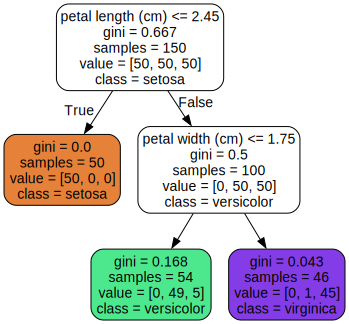

In [3]:
# we can visualize the decision tree with graphviz

from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

from graphviz import Source

Source.from_file("iris_tree.dot")

Using figure above, lets suppose you find an iris flower and want to classify it based on its petals. 
- You start at the _root node_ (depth 0, at the top): this node asks whether the flower's petal length is smaller than 2.45cm.
- If it is, then we move to the left child node, in this case its a leaf node, so it doesnt ask any questions and just makes a prediction that the flower is an _Iris setosa_
- For other case, its a similar approach

The node's _samples_ attribute counts how many training instances the node applies to.

The _gini_ attribute measures its _Gini impurity_:
- a node is pure (gini = 0) if all its training instances apply to the same class
- the _value_ node tells us how many of each class the node has
- $p_{i,k}$ is the ratio of class k instances among the training instances in the ith node
- so the Gini impurity is calculated as $$ G_{i} = 1 - \sum^{n}_{k=1} p_{i,k}^{2} $$

So for the bottom left node, the calculation is 
$ 1 – (0/54)^2 – (49/54)^2 – (5/54)^2 ≈ 0.168$

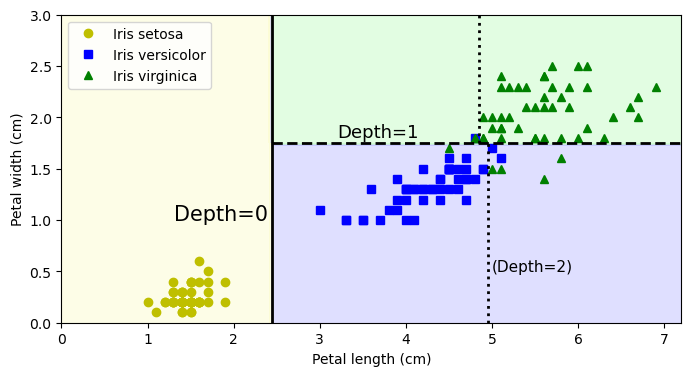

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies and saves Figure 6–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
# save_fig("decision_tree_decision_boundaries_plot")

plt.show()

Above figure shows the decision tree's boundaries. The thick vertical line represents the decision boundary of the root node. Since the lefthand area is pure (only _Iris setosa_), it cannot be split any further.

The righthand area is impure, so the Depth=1 right node splits at petal-width = 1.75cm. Since the max-depth was set to 2, the decision tree stops here.
If we set the the max-depth to 3, then the two depth-two nodes would each add a decision boundary (represented by the two vertical dotted lines).

Decision trees provide nice, simple classification rules that can be applied manually, so they are ofen called _white box models_. Unlike random forests and neural networks, which are often called _black box models_.

**Estimating Class probabilities**

In [8]:
 # predicts probabilities for each class
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [7]:
# predicts class 1, Iris Setosa, since it has highest probability
tree_clf.predict([[5, 1.5]]) 

array([1])

sk-learn uses the CART training algorithm, which produces binary trees.

**Regularization Hyperparameters**

Decision trees tend to overfit, because they are free to pick any number of parameters. To avoid this we need to restrict the decision tree's freedom during training. As we know by now, this is called regularization.
The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the decision tree.
In sk-learn, this is controlled by the _max_depth_ hyperparameter. The default value is _None_, which means unlimited.

In [9]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

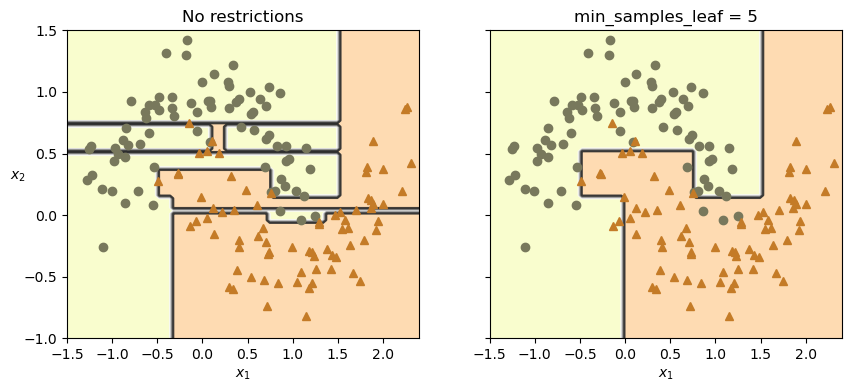

In [10]:
# extra code – this cell generates and saves Figure 6–3

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
# save_fig("min_samples_leaf_plot")
plt.show()

**Sensitivity to Axis Orientation**

Hopefully by now you are convinced that decision trees have a lot going for them: they are relatively easy to understand and interpret, simple to use, versatile, and powerful. However, they do have a few limitations.

First, as you may have noticed, decision trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to the data’s orientation

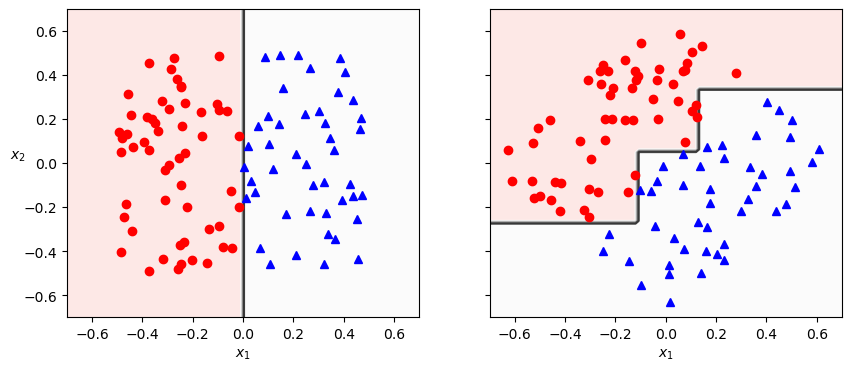

In [11]:
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

# save_fig("sensitivity_to_rotation_plot")
plt.show()

For example, above figure shows a simple linearly separable dataset: on the left, a decision tree can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily convoluted.

Although both decision trees fit the training set perfectly, it
is very likely that the model on the right will not generalize well.

One way to limit this problem is to scale the data, then apply a principal component analysis transformation. We will look at PCA in detail in Chapter 8, but for now we only need to know that it rotates the data in a way that reduces the correlation between the features, which often (not always) makes things easier for trees.

Let’s create a small pipeline that scales the data and rotates it using PCA, then train a DecisionTreeClassifier on that data.

In [12]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

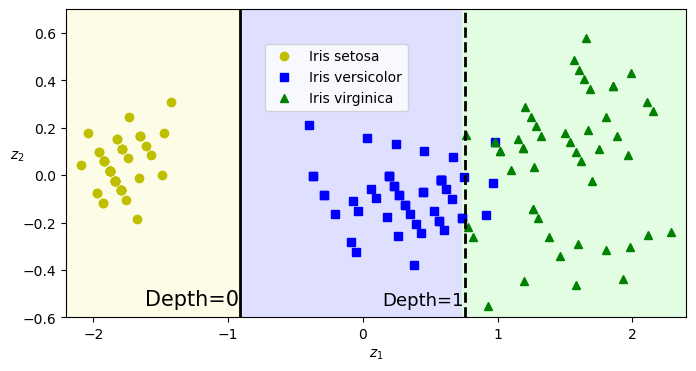

In [13]:
# extra code – this cell generates and saves Figure 6–8

plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))
# save_fig("pca_preprocessing_plot")

plt.show()

Above figure shows the decision boundaries of that tree: as you can see, the rotation makes it possible to fit the dataset pretty well using only one feature, z1, which is a linear function of the original petal length and width. 

**Decision Trees Have a High Variance**

More generally, the main issue with decision trees is that they have quite a high variance: small changes to the hyperparameters or to the data may produce very different models.

In fact, since the training algorithm used by Scikit-Learn is stochastic— it randomly selects the set of features to evaluate at each node— even retraining the same decision tree on the exact same data may produce a very different model

**Luckily, by averaging predictions over many trees, it’s possible to reduce variance significantly. Such an ensemble of trees is called a random forest, and it’s one of the most powerful types of models available today, as you will see in the next chapter.**